In [12]:
import h5py
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
import shutil
import glob
import optparse
import os
import json
import pandas as pd
import numpy as np
import pylab as pl
import scipy.stats as stats
import seaborn as sns
sns.set_style("ticks")
sns.set()
sns.set_color_codes()

def findOccurrences(s, ch):
    return [i for i, letter in enumerate(s) if letter == ch]

def normalize_across_rows(in_array):

    min_val = np.min(in_array,0)
    max_val = np.max(in_array,0)

    min_mat = np.tile(min_val,(in_array.shape[0],1))
    max_mat = np.tile(max_val,(in_array.shape[0],1))
    range_mat = max_mat - min_mat

    out_array = np.true_divide(in_array-min_mat,range_mat)

    out_array[np.isnan(out_array)] = 0
    
    return out_array


def get_upper_triangle_values(in_array):
    mask = np.ones(in_array.shape)
    tmp = np.tril(mask,0)
    out_val = in_array[np.where(tmp==0)]
    
    return out_val

def correlate_split_half_RDM(half1_array,half2_array):
    R_all_half1 = np.corrcoef(half1_array)
    R_all_half2 = np.corrcoef(half2_array)

    all_half1_values = get_upper_triangle_values(R_all_half1)
    all_half2_values = get_upper_triangle_values(R_all_half2)
    
    R = np.corrcoef(all_half1_values,all_half2_values)
    
    return R[0,1]

In [3]:


dset_list = ['V1_JC085_20190624','V1_JC085_20190712','V1_JC097_20190621','V1_JC097_20190628',\
             'V1_JC097_20190704',\
             'LM_JC080_20190619','LM_JC091_20190621','LM_JC091_20190703','LM_JC091_20190628',\
             'LM_JC097_20190702','LM_JC097_20190708','LM_JC085_20190704',\
             'LI_JC091_20190625','LI_JC091_20190701','LI_JC091_20190705'
            ]


response_type = 'df'

filter_crit = 'zscore'
filter_thresh = 1

#define paths
aggregate_root = '/n/coxfs01/cechavarria/2p-aggregate/scenes'
fig_base_dir = os.path.join(aggregate_root,'RSA_per_sessions','figures')



In [20]:
#get responses
area_list = ['V1','LM','LI']
animalid_list = []
sess_count = []
areaid = np.zeros((len(dset_list,)))
animalid = np.zeros((len(dset_list,)))
sessid = np.zeros((len(dset_list,)))

R_values_array = []
R_zscore_values_array = []
R_norm_values_array = []

R_active_values_array = []
R_active_zscore_values_array = []
R_active_norm_values_array = []

Rself_response_all = np.zeros((len(dset_list,)))
Rself_response_active = np.zeros((len(dset_list,)))
Rself_response_all_zscore = np.zeros((len(dset_list,)))
Rself_response_active_zscore = np.zeros((len(dset_list,)))
Rself_response_all_norm = np.zeros((len(dset_list,)))
Rself_response_active_norm = np.zeros((len(dset_list,)))

fig_out_dir = os.path.join(fig_base_dir,'per_session')
if not os.path.isdir(fig_out_dir):
        os.makedirs(fig_out_dir)

for dset_idx, dset in enumerate(dset_list):
    # dset_idx = 0
    # dset = dset_list[dset_idx]

    #figure out some indexes
    i0 = findOccurrences(dset,'_')[0]
    i1 = findOccurrences(dset,'_')[1]

    area = dset[0:i0]
    animal = dset[i0+1:i1]
    session = dset[i1+1:]

    if animal not in animalid_list:
        animalid_list.append(animal)
        sess_count.append(0)

    sess_count[animalid_list.index(animal)] = sess_count[animalid_list.index(animal)]+1

    areaid[dset_idx] = area_list.index(area)
    animalid[dset_idx] = animalid_list.index(animal)
    sessid[dset_idx] = sess_count[animalid_list.index(animal)]-1


    #load data
    aggregate_file_dir = os.path.join(aggregate_root,area,'files','filtered_responses')
    data_array_fn = '%s_%s_filtered_%s_responses_thresh_%s_%i.hdf5'%(animal, session, response_type, filter_crit, filter_thresh)
    data_array_filepath = os.path.join(aggregate_file_dir, data_array_fn)
    data_grp = h5py.File(data_array_filepath, 'r')

    curr_slice = 'Slice01'#hard-code planar data for now
    active_cell_idx = np.array(data_grp['/'.join([curr_slice, 'active_cell_idx'])])
    dset_response = np.array(data_grp['/'.join([curr_slice, 'unfiltered_response_per_cfg_per_neuron'])])
    dset_response_active = dset_response[:,active_cell_idx]

    #get correlation
    R_dset = np.corrcoef(dset_response)
    R_dset_active = np.corrcoef(dset_response_active)

    #z-score and get correlation
    dset_response_zscore = stats.zscore(dset_response,0)
    dset_response_active_zscore = stats.zscore(dset_response_active,0)

    dset_response_zscore[np.isnan(dset_response_zscore)]=0
    dset_response_active_zscore[np.isnan(dset_response_active_zscore)]=0

    R_dset_zscore = np.corrcoef(dset_response_zscore)
    R_dset_active_zscore = np.corrcoef(dset_response_active_zscore)

    #normalize and get correlation
    dset_response_norm = normalize_across_rows(dset_response)
    dset_response_active_norm = normalize_across_rows(dset_response_active)

    R_dset_norm = np.corrcoef(dset_response_norm)
    R_dset_active_norm = np.corrcoef(dset_response_active_norm)


    #plot correlation matrices
    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(R_dset,center = 0,annot=False, cmap = 'RdBu_r')

    fig_name = '%s_%s_%s_raw_%s_RSA.png'%(animal,session,area,response_type)
    fig_fn = os.path.join(fig_out_dir,fig_name)

    fig = ax.get_figure()
    fig.savefig(fig_fn) 
    plt.close()

    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(R_dset_active,center = 0,annot=False, cmap = 'RdBu_r')

    fig_name = '%s_%s_%s_active_raw_%s_RSA.png'%(animal,session,area,response_type)
    fig_fn = os.path.join(fig_out_dir,fig_name)

    fig = ax.get_figure()
    fig.savefig(fig_fn) 
    plt.close()


    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(R_dset_zscore,center = 0,annot=False, cmap = 'RdBu_r')

    fig_name = '%s_%s_%s_zscore_%s_RSA.png'%(animal,session,area,response_type)
    fig_fn = os.path.join(fig_out_dir,fig_name)

    fig = ax.get_figure()
    fig.savefig(fig_fn) 
    plt.close()

    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(R_dset_active_zscore,center = 0,annot=False, cmap = 'RdBu_r')

    fig_name = '%s_%s_%s_active_zscore_%s_RSA.png'%(animal,session,area,response_type)
    fig_fn = os.path.join(fig_out_dir,fig_name)

    fig = ax.get_figure()
    fig.savefig(fig_fn) 
    plt.close()


    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(R_dset_norm,center = 0,annot=False, cmap = 'RdBu_r')

    fig_name = '%s_%s_%s_norm_%s_RSA.png'%(animal,session,area,response_type)
    fig_fn = os.path.join(fig_out_dir,fig_name)

    fig = ax.get_figure()
    fig.savefig(fig_fn) 
    plt.close()

    plt.figure(figsize=(12, 10))
    ax = sns.heatmap(R_dset_active_norm,center = 0,annot=False, cmap = 'RdBu_r')

    fig_name = '%s_%s_%s_active_norm_%s_RSA.png'%(animal,session,area,response_type)
    fig_fn = os.path.join(fig_out_dir,fig_name)

    fig = ax.get_figure()
    fig.savefig(fig_fn) 
    plt.close()

    ncells = dset_response_zscore.shape[1]

    dset_response_all_half1 = dset_response[:,0:ncells:2]
    dset_response_active_half1 = dset_response_active[:,0:ncells:2]
    dset_response_all_zscore_half1 = dset_response_zscore[:,0:ncells:2]
    dset_response_active_zscore_half1 = dset_response_active_zscore[:,0:ncells:2]
    dset_response_all_norm_half1 = dset_response_zscore[:,0:ncells:2]
    dset_response_active_norm_half1 = dset_response_active_norm[:,0:ncells:2]

    dset_response_all_half2 = dset_response[:,1:ncells:2]
    dset_response_active_half2 = dset_response_active[:,1:ncells:2]
    dset_response_all_zscore_half2 = dset_response_zscore[:,1:ncells:2]
    dset_response_active_zscore_half2 = dset_response_zscore[:,1:ncells:2]
    dset_response_all_norm_half2 = dset_response_zscore[:,1:ncells:2]
    dset_response_active_norm_half2 = dset_response_active_norm[:,1:ncells:2]

    Rself_response_all[dset_idx] = correlate_split_half_RDM(dset_response_all_half1,dset_response_all_half2)
    Rself_response_active[dset_idx] = correlate_split_half_RDM(dset_response_active_half1,dset_response_active_half2)

    Rself_response_all_zscore[dset_idx] = correlate_split_half_RDM(dset_response_all_zscore_half1,dset_response_all_zscore_half2)
    Rself_response_active_zscore[dset_idx] = correlate_split_half_RDM(dset_response_active_zscore_half1,dset_response_active_zscore_half2)

    Rself_response_all_norm[dset_idx] = correlate_split_half_RDM(dset_response_all_norm_half1,dset_response_all_norm_half2)
    Rself_response_active_norm[dset_idx] = correlate_split_half_RDM(dset_response_active_norm_half1,dset_response_active_norm_half2)



    #get values
    R_dset_values = get_upper_triangle_values(R_dset)
    R_dset_zscore_values = get_upper_triangle_values(R_dset_zscore)
    R_dset_norm_values = get_upper_triangle_values(R_dset_norm)

    R_dset_active_values = get_upper_triangle_values(R_dset_active)
    R_dset_active_zscore_values = get_upper_triangle_values(R_dset_active_zscore)
    R_dset_active_norm_values = get_upper_triangle_values(R_dset_active_norm)

    #save to array
    if len(R_values_array)==0:
        R_values_array = R_dset_values
        R_zscore_values_array = R_dset_zscore_values
        R_norm_values_array = R_dset_zscore_values
        R_active_values_array = R_dset_active_values
        R_active_zscore_values_array = R_dset_active_zscore_values
        R_active_norm_values_array = R_dset_active_zscore_values
    else:
        R_values_array = np.vstack((R_values_array,R_dset_values))
        R_zscore_values_array = np.vstack((R_zscore_values_array,R_dset_zscore_values))
        R_norm_values_array = np.vstack((R_norm_values_array,R_dset_norm_values))
        R_active_values_array = np.vstack((R_active_values_array,R_dset_active_values))
        R_active_zscore_values_array = np.vstack((R_active_zscore_values_array,R_dset_active_zscore_values))
        R_active_norm_values_array = np.vstack((R_active_norm_values_array,R_dset_active_norm_values))

/home/cesar/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/home/cesar/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


In [29]:
#correlate values across sessions
R_across_sessions = np.corrcoef(R_values_array)
R_zscore_across_sessions = np.corrcoef(R_zscore_values_array)
R_norm_across_sessions = np.corrcoef(R_norm_values_array)

R_active_across_sessions = np.corrcoef(R_active_values_array)
R_active_zscore_across_sessions = np.corrcoef(R_active_zscore_values_array)
R_active_norm_across_sessions = np.corrcoef(R_active_norm_values_array)


In [32]:
#replace diagnonal values
for dset_idx, dset in enumerate(dset_list):
    R_across_sessions[dset_idx,dset_idx] = Rself_response_all[dset_idx]
    R_active_across_sessions[dset_idx,dset_idx] = Rself_response_active[dset_idx]
    
    R_zscore_across_sessions[dset_idx,dset_idx] = Rself_response_all_zscore[dset_idx]
    R_active_zscore_across_sessions[dset_idx,dset_idx] = Rself_response_active_zscore[dset_idx]
    
    R_norm_across_sessions[dset_idx,dset_idx] = Rself_response_all_norm[dset_idx]
    R_active_norm_across_sessions[dset_idx,dset_idx] = Rself_response_active_norm[dset_idx]

In [26]:
#plot cross-session correlation matrices
fig_out_dir = os.path.join(fig_base_dir,'across_sessions')
if not os.path.isdir(fig_out_dir):
        os.makedirs(fig_out_dir)


In [38]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_across_sessions,yticklabels=dset_list,xticklabels = False,center = 0, cmap = 'RdBu_r',vmin = -1 , vmax = 1)

fig_name = 'R_across_sessions_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_active_across_sessions,yticklabels=dset_list,xticklabels = False,center = 0, cmap = 'RdBu_r',vmin = -1 , vmax = 1)

fig_name = 'R_active_across_sessions_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_zscore_across_sessions,yticklabels=dset_list,xticklabels = False,center = 0, cmap = 'RdBu_r',vmin = -1 , vmax = 1)

fig_name = 'R_zscore_across_sessions_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_active_zscore_across_sessions,yticklabels=dset_list,xticklabels = False,center = 0, cmap = 'RdBu_r',vmin = -1 , vmax = 1)

fig_name = 'R_active_zscore_across_sessions_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_norm_across_sessions,yticklabels=dset_list,xticklabels = False,center = 0, cmap = 'RdBu_r',vmin = -1 , vmax = 1)

fig_name = 'R_norm_across_sessions_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_active_norm_across_sessions,yticklabels=dset_list,xticklabels = False,center = 0, cmap = 'RdBu_r',vmin = -1 , vmax = 1)

fig_name = 'R_active_norm_across_sessions_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()




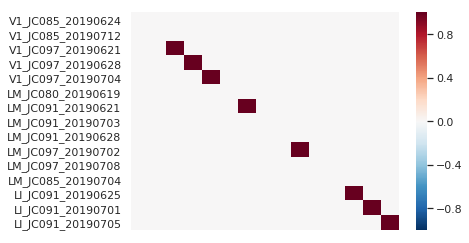

In [68]:
ax = sns.heatmap(R_active_zscore_across_sessions>0.5,yticklabels=dset_list,xticklabels = False,center = 0, cmap = 'RdBu_r',vmin = -1 , vmax = 1)


In [46]:
R_resp_area = np.zeros((np.unique(areaid).size,np.unique(areaid).size))
area_pairs = np.meshgrid(areaid,areaid)

for area_idx1 in np.unique(areaid):
    area_idx1 = int(area_idx1)
    for area_idx2 in np.unique(areaid):
        area_idx2 = int(area_idx2)

        M1 = np.array(area_pairs[0]==area_idx1).astype('float64')
        M2 = np.array(area_pairs[1]==area_idx2).astype('float64')

        M = M1*M2
       # M = np.tril(M,-1)
        M[np.diag_indices(M.shape[0])] = np.nan
        M[np.where(M==0)] = np.nan

        R_masked = R_active_zscore_across_sessions*M

        R_resp_area[area_idx1,area_idx2]= np.nanmean(R_masked.flatten())

In [47]:
R_resp_area

array([[0.34726889, 0.29746397, 0.22833068],
       [0.29746397, 0.27905365, 0.23933113],
       [0.22833068, 0.23933113, 0.31515791]])

In [64]:
plt.figure(figsize=(12, 10))
ax = sns.heatmap(R_resp_area,yticklabels=area_list,xticklabels = False,center = 0,annot = True, cmap = 'RdBu_r',vmin = 0 , vmax = 1)

fig_name = 'R_active_zscore_mean_across_sessions_per_area_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)

fig = ax.get_figure()
fig.savefig(fig_fn) 
plt.close()


In [62]:
R_resp = R_active_zscore_across_sessions

fig_name = 'mean_R_active_zscore_across_configs_%s_RSA.png'%(response_type)
fig_fn = os.path.join(fig_out_dir,fig_name)


V1_same_animal_diff_session_idxs = [[0,2,2,3],[1,3,4,4]]
V1_same_animal_diff_session_filt=np.zeros((len(dset_list),len(dset_list)))
V1_same_animal_diff_session_filt[V1_same_animal_diff_session_idxs]=1
V1_same_animal_diff_session_R_resp = R_resp[V1_same_animal_diff_session_idxs]

#ax = sns.heatmap(V1_same_animal_diff_session_filt,yticklabels=dset_list,xticklabels = False,linewidths = 0.5, cmap = 'RdBu_r')

V1_diff_animal_idxs = [[0,0,0,1,1,1],[2,3,4,2,3,4]]
V1_diff_animal_filt=np.zeros((len(dset_list),len(dset_list)))
V1_diff_animal_filt[V1_diff_animal_idxs]=1
V1_diff_animal_R_resp = R_resp[V1_diff_animal_idxs]

#ax = sns.heatmap(V1_diff_animal_filt,yticklabels=dset_list,xticklabels = False,linewidths = 0.5, cmap = 'RdBu_r')

LM_same_animal_diff_session_idxs = [[6,6,7,9],[7,8,8,10]]
LM_same_animal_diff_session_filt=np.zeros((len(dset_list),len(dset_list)))
LM_same_animal_diff_session_filt[LM_same_animal_diff_session_idxs]=1
LM_same_animal_diff_session_R_resp = R_resp[LM_same_animal_diff_session_idxs]

#ax = sns.heatmap(LM_same_animal_diff_session_filt,yticklabels=dset_list,xticklabels = False,linewidths = 0.5, cmap = 'RdBu_r')


LM_diff_animal_idxs = [[5,5,5,5, 5, 5, 6, 6, 6,7, 7, 7,8, 8, 8, 9, 9,10],\
                       [6,7,8,9,10,11,9,10,11,9,10,11,9,10,11,10,11,11]]
LM_diff_animal_filt=np.zeros((len(dset_list),len(dset_list)))
LM_diff_animal_filt[LM_diff_animal_idxs]=1
LM_diff_animal_R_resp = R_resp[LM_diff_animal_idxs]

#ax = sns.heatmap(LM_diff_animal_filt,yticklabels=dset_list,xticklabels = False,linewidths = 0.5, cmap = 'RdBu_r')


LI_same_animal_diff_session_idxs = [[12,12,13],[13,14,14]]
LI_same_animal_diff_session_filt=np.zeros((len(dset_list),len(dset_list)))
LI_same_animal_diff_session_filt[LI_same_animal_diff_session_idxs]=1
LI_same_animal_diff_session_R_resp = R_resp[LI_same_animal_diff_session_idxs]

#ax = sns.heatmap(LI_same_animal_diff_session_filt,yticklabels=dset_list,xticklabels = False,linewidths = 0.5, cmap = 'RdBu_r')


V1_same_animal_diff_session_resp_mean = np.mean(V1_same_animal_diff_session_R_resp)
V1_diff_animal_resp_mean = np.mean(V1_diff_animal_R_resp)

LM_same_animal_diff_session_resp_mean = np.mean(LM_same_animal_diff_session_R_resp)
LM_diff_animal_resp_mean = np.mean(LM_diff_animal_R_resp)

LI_same_animal_diff_session_resp_mean = np.mean(LI_same_animal_diff_session_R_resp)

plt.figure(figsize=(6, 5))

plt.bar(0, V1_same_animal_diff_session_resp_mean,width=0.5,color = 'b',alpha = 0.5)
plt.bar(0.5, V1_diff_animal_resp_mean,width=0.5,color = 'b',alpha = 0.5)
plt.scatter(np.ones(V1_same_animal_diff_session_R_resp.size)*0,V1_same_animal_diff_session_R_resp,color = 'k')
plt.scatter(np.ones(V1_diff_animal_R_resp.size)*0.5,V1_diff_animal_R_resp,color = 'k')

plt.bar(1.5, LM_same_animal_diff_session_resp_mean,width=0.5,color = 'c',alpha = 0.5)
plt.bar(2, LM_diff_animal_resp_mean,width=0.5,color = 'c',alpha = 0.5)
plt.scatter(np.ones(LM_same_animal_diff_session_R_resp.size)*1.5,LM_same_animal_diff_session_R_resp,color = 'k')
plt.scatter(np.ones(LM_diff_animal_R_resp.size)*2,LM_diff_animal_R_resp,color = 'k')

plt.bar(3, LI_same_animal_diff_session_resp_mean,width=0.5,color = 'm',alpha = 0.5)
plt.scatter(np.ones(LI_same_animal_diff_session_R_resp.size)*3,LI_same_animal_diff_session_R_resp,color = 'k')

plt.xlabel('Configuration')
plt.ylabel('Average Correlation')
plt.xticks([0,0.5,1.5,2,3],['V1_sads','V1_da','LM_sads','LM_da','LI_sads'])
#plt.set_xtickslabels([''])

plt.savefig(fig_fn) 
plt.close()

/home/cesar/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
/home/cesar/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # Remove the CWD from sys.path while we load stuff.
/home/cesar/envs/suite2p/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In th

In [ ]:
#get responses
area_list = ['V1','LM','LI']
animalid_list = []
sess_count = []
areaid = np.zeros((len(dset_list,)))
animalid = np.zeros((len(dset_list,)))
sessid = np.zeros((len(dset_list,)))



for dset_idx, dset in enumerate(dset_list):
    # dset_idx = 0
    # dset = dset_list[dset_idx]

    #figure out some indexes
    i0 = findOccurrences(dset,'_')[0]
    i1 = findOccurrences(dset,'_')[1]

    area = dset[0:i0]
    animal = dset[i0+1:i1]
    session = dset[i1+1:]

    if animal not in animalid_list:
        animalid_list.append(animal)
        sess_count.append(0)

    sess_count[animalid_list.index(animal)] = sess_count[animalid_list.index(animal)]+1

    areaid[dset_idx] = area_list.index(area)
    animalid[dset_idx] = animalid_list.index(animal)
    sessid[dset_idx] = sess_count[animalid_list.index(animal)]-1


    #load data
    aggregate_file_dir = os.path.join(aggregate_root,area,'files')
    data_array_fn = '%s_%s_filtered_%s_responses_thresh_%s_%i.hdf5'%(animal, session, response_type, filter_crit, filter_thresh)
    data_array_filepath = os.path.join(aggregate_file_dir, data_array_fn)
    data_grp = h5py.File(data_array_filepath, 'r')
    
    config_cond = np.array(data_grp['config_cond'])

    curr_slice = 'Slice01'#hard-code planar data for now
    
   
    dset_count = np.array(data_grp['/'.join([curr_slice, 'active_rois_per_config'])])


    #store in array
    if dset_idx ==0:
        dset_count_array = dset_count
    else:
        dset_count_array = np.vstack((dset_count_array,dset_count))
        


In [ ]:

R_count = np.corrcoef(dset_count_array)

In [ ]:
ax = sns.heatmap(R_count,yticklabels=dset_list,xticklabels = False,center = 0, cmap = 'RdBu_r')


In [ ]:
R_count_area = np.zeros((np.unique(areaid).size,np.unique(areaid).size))
area_pairs = np.meshgrid(areaid,areaid)

for area_idx1 in np.unique(areaid):
    area_idx1 = int(area_idx1)
    for area_idx2 in np.unique(areaid):
        area_idx2 = int(area_idx2)

        M1 = np.array(area_pairs[0]==area_idx1).astype('float64')
        M2 = np.array(area_pairs[1]==area_idx2).astype('float64')

        M = M1*M2
        M[np.diag_indices(M.shape[0])] = np.nan
        M[np.where(M==0)] = np.nan

        R_masked = R_count*M

        R_count_area[area_idx1,area_idx2]= np.nanmean(R_masked.flatten())

sns.heatmap(R_count_area,yticklabels=area_list,xticklabels = area_list,center = 0, cmap = 'RdBu_r')

In [ ]:
V1_same_animal_diff_session_R_count = R_count[V1_same_animal_diff_session_idxs]
V1_diff_animal_R_count = R_count[V1_diff_animal_idxs]

LM_same_animal_diff_session_R_count = R_count[LM_same_animal_diff_session_idxs]
LM_diff_animal_R_count = R_count[LM_diff_animal_idxs]
LI_same_animal_diff_session_R_count = R_count[LI_same_animal_diff_session_idxs]



In [ ]:
V1_same_animal_diff_session_count_mean = np.mean(V1_same_animal_diff_session_R_count)
V1_diff_animal_count_mean = np.mean(V1_diff_animal_R_count)

LM_same_animal_diff_session_count_mean = np.mean(LM_same_animal_diff_session_R_count)
LM_diff_animal_count_mean = np.mean(LM_diff_animal_R_count)

LI_same_animal_diff_session_count_mean = np.mean(LI_same_animal_diff_session_R_count)

In [ ]:
ndsets,nconfigs = dset_count_array.shape
nreps = 1000

V1_sadf_R_count = np.zeros((nreps,))
LM_sadf_R_count = np.zeros((nreps,))
LI_sadf_R_count = np.zeros((nreps,))
V1_da_R_count = np.zeros((nreps,))
LM_da_R_count = np.zeros((nreps,))

for rep in range(nreps):
#rep = 0 

    dset_count_array_shuffle = np.copy(dset_count_array)
    dset_count_array_shuffle = np.random.permutation(dset_count_array_shuffle.flatten())
    dset_count_array_shuffle = np.reshape(dset_count_array_shuffle,(ndsets,nconfigs))

    R_count_tmp = np.corrcoef(dset_count_array_shuffle)

    V1_sadf_R_count[rep] = np.mean(R_count_tmp[V1_same_animal_diff_session_idxs])
    V1_da_R_count[rep] = np.mean(R_count_tmp[V1_diff_animal_idxs])

    LM_sadf_R_count[rep] = np.mean(R_count_tmp[LM_same_animal_diff_session_idxs])
    LM_da_R_count[rep] = np.mean(R_count_tmp[LM_diff_animal_idxs])

    LI_sadf_R_count[rep] = np.mean(R_count_tmp[LI_same_animal_diff_session_idxs])

In [ ]:
V1_sadf_count_bstrap_mean = np.mean(V1_sadf_R_count)
V1_da_count_bstrap_mean = np.mean(V1_da_R_count)
V1_sadf_count_bstrap_se = stats.sem(V1_sadf_R_count)
V1_da_count_bstrap_se = stats.sem(V1_da_R_count)

LM_sadf_count_bstrap_mean = np.mean(V1_sadf_R_count)
LM_da_count_bstrap_mean = np.mean(V1_da_R_count)
LM_sadf_count_bstrap_se = stats.sem(LM_sadf_R_count)
LM_da_count_bstrap_se = stats.sem(LM_da_R_count)

LI_sadf_count_bstrap_mean = np.mean(V1_sadf_R_count)
LI_sadf_count_bstrap_se = stats.sem(LM_sadf_R_count)

In [ ]:
width = 0.5
bar_loc = [0,0.5,1.5,2,3]
plt.bar(bar_loc[0], V1_same_animal_diff_session_count_mean,width = width ,color = 'b')
plt.bar(bar_loc[1], V1_diff_animal_count_mean,width = width,color = 'b')

plt.bar(bar_loc[2], LM_same_animal_diff_session_count_mean,width = width,color = 'c')
plt.bar(bar_loc[3], LM_diff_animal_count_mean,width = width,color = 'c')

plt.bar(bar_loc[4], LI_same_animal_diff_session_count_mean,width = width,color = 'm')

plt.hlines(y = V1_sadf_count_bstrap_mean+(1.96*V1_sadf_count_bstrap_se),xmin = bar_loc[0]-(width/2), xmax = bar_loc[0]+(width/2), linestyle = '--')
plt.hlines(y = V1_sadf_count_bstrap_mean-(1.96*V1_sadf_count_bstrap_se),xmin = bar_loc[0]-(width/2), xmax = bar_loc[0]+(width/2), linestyle = '--')
plt.hlines(y = V1_da_count_bstrap_mean+(1.96*V1_da_count_bstrap_se),xmin = bar_loc[1]-(width/2), xmax = bar_loc[1]+(width/2), linestyle = '--')
plt.hlines(y = V1_da_count_bstrap_mean-(1.96*V1_da_count_bstrap_se),xmin = bar_loc[1]-(width/2), xmax = bar_loc[1]+(width/2), linestyle = '--')

plt.hlines(y = LM_sadf_count_bstrap_mean+(1.96*LM_sadf_count_bstrap_se),xmin = bar_loc[2]-(width/2), xmax = bar_loc[2]+(width/2), linestyle = '--')
plt.hlines(y = LM_sadf_count_bstrap_mean-(1.96*LM_sadf_count_bstrap_se),xmin = bar_loc[2]-(width/2), xmax = bar_loc[2]+(width/2), linestyle = '--')
plt.hlines(y = LM_da_count_bstrap_mean+(1.96*LM_da_count_bstrap_se),xmin = bar_loc[3]-(width/2), xmax = bar_loc[3]+(width/2), linestyle = '--')
plt.hlines(y = LM_da_count_bstrap_mean-(1.96*LM_da_count_bstrap_se),xmin = bar_loc[3]-(width/2), xmax = bar_loc[3]+(width/2), linestyle = '--')

plt.hlines(y = LI_sadf_count_bstrap_mean+(1.96*LI_sadf_count_bstrap_se),xmin = bar_loc[4]-(width/2), xmax = bar_loc[4]+(width/2), linestyle = '--')
plt.hlines(y = LI_sadf_count_bstrap_mean-(1.96*LI_sadf_count_bstrap_se),xmin = bar_loc[4]-(width/2), xmax = bar_loc[4]+(width/2), linestyle = '--')

In [ ]:
V1_session_R = np.zeros((2,2))

area_idx1 = 0
area_idx2 = 0
animal_idx1 = 0
animal_idx2 = 0
sessid_idx1 = 0
sessid_idx2 = 1

M1 = np.array(area_pairs[0]==area_idx1).astype('float64')
M2 = np.array(area_pairs[1]==area_idx2).astype('float64')
M3 = np.array(animal_pairs[0]==animal_idx1).astype('float64')
M4 = np.array(animal_pairs[1]==animal_idx2).astype('float64')
M5 = np.array(session_pairs[0]==sessid_idx1).astype('float64')
M6 = np.array(session_pairs[1]==sessid_idx2).astype('float64')

M = M1*M2*M3*M4*M5*M6

M[np.diag_indices(M.shape[0])] = np.nan
M[np.where(M==0)] = np.nan



animal_idx1 = 1
animal_idx2 = 1
sessid_idx1 = 0
sessid_idx2 = 1

M1 = np.array(area_pairs[0]==area_idx1).astype('float64')
M2 = np.array(area_pairs[1]==area_idx2).astype('float64')
M3 = np.array(animal_pairs[0]==animal_idx1).astype('float64')
M4 = np.array(animal_pairs[1]==animal_idx2).astype('float64')
M5 = np.array(session_pairs[0]==sessid_idx1).astype('float64')
M6 = np.array(session_pairs[1]==sessid_idx2).astype('float64')

M = M1*M2*M3*M4*M5*M6

M[np.diag_indices(M.shape[0])] = np.nan
M[np.where(M==0)] = np.nan

R_masked = M*R_count
V1_session_R[0,1] = np.nanmean(R_masked.flatten())

animal_idx1 = 0
animal_idx2 = 1
sessid_idx1 = 0
sessid_idx2 = 0

M1 = np.array(area_pairs[0]==area_idx1).astype('float64')
M2 = np.array(area_pairs[1]==area_idx2).astype('float64')
M3 = np.array(animal_pairs[0]==animal_idx1).astype('float64')
M4 = np.array(animal_pairs[1]==animal_idx2).astype('float64')


M = M1*M2*M3*M4

M[np.diag_indices(M.shape[0])] = np.nan
M[np.where(M==0)] = np.nan

R_masked = M*R_count
V1_session_R[1,0] = np.nanmean(R_masked.flatten())

animal_idx1 = 1
animal_idx2 = 0
sessid_idx1 = 0
sessid_idx2 = 0

M1 = np.array(area_pairs[0]==area_idx1).astype('float64')
M2 = np.array(area_pairs[1]==area_idx2).astype('float64')
M3 = np.array(animal_pairs[0]==animal_idx1).astype('float64')
M4 = np.array(animal_pairs[1]==animal_idx2).astype('float64')


M = M1*M2*M3*M4

M[np.diag_indices(M.shape[0])] = np.nan
M[np.where(M==0)] = np.nan

R_masked = M*R_count
V1_session_R[1,1] = np.nanmean(R_masked.flatten())

In [ ]:
V1_session_R

In [ ]:
sns.heatmap(V1_session_R,center = 0, cmap = 'RdBu_r')

In [ ]:
V1_V1 = []
idx_list0 = np.where(areaid==0)[0]#V1
idx_list1 = np.where(areaid==1)[0]#LM
idx_list2 = np.where(areaid==2)[0]#LI

for i in idx_list0:
    for j in idx_list0:
        if j<i:
            V1_V1.append(R_count[i,j])
V1_V1 = np.array(V1_V1)
            
V1_LM = []
for i in idx_list1:
    for j in idx_list0:
        if j<i:
            V1_LM.append(R_count[i,j])
V1_LM = np.array(V1_LM)

V1_LI = []
for i in idx_list2:
    for j in idx_list0:
        if j<i:
            V1_LI.append(R_count[i,j])
V1_LI = np.array(V1_LI)
            
LM_LI = []
for i in idx_list2:
    for j in idx_list1:
        if j<i:
            LM_LI.append(R_count[i,j])
LM_LI = np.array(LM_LI)


In [ ]:
V1_V1

In [ ]:
V1_LM

In [ ]:
V1_LI

In [ ]:
print(np.mean(V1_V1),np.mean(V1_LM),np.mean(V1_LI))

In [ ]:


fig,axes = plt.subplots(num_animals,num_session,figsize=(20,20))

if num_animals <2:
    axes = np.expand_dims(axes,0)



    data_array_fn = '%s_filtered_%s_responses_thresh_%s_%i.hdf5'%(sess, response_type, filter_crit, filter_thresh)
    data_array_filepath = os.path.join(aggregate_file_dir, data_array_fn)
    data_grp = h5py.File(data_array_filepath, 'r')



    curr_slice = 'Slice01'#hard-code planar data for now

    num_active_rois = int(np.array(data_grp['/'.join([curr_slice,'n_active_rois'])]))
    frac_active_rois = float(np.array(data_grp['/'.join([curr_slice,'frac_active_rois'])]))

    neuron_count = num_active_rois
    neuron_frac = frac_active_rois

    
    response_se = np.array(data_grp['/'.join([curr_slice, 'filtered_response_per_cond_se_across_neurons'])])


    
    ax = axes[animalids.index(animalid),sess_count[animalids.index(animalid)]-1]
    ax.bar(bar_loc[0],sess_response[0],width,color = 'b', alpha = 1, yerr = response_se[0])
    ax.bar(bar_loc[1],sess_response[1],width,color = 'r', alpha = 1, yerr = response_se[0])
    ax.bar(bar_loc[2],sess_response[2],width,color = 'g', alpha = 1, yerr = response_se[0])
    
    ymin,ymax = ax.get_ylim()
    xmin,xmax = ax.get_xlim()
    ax.set_xticks([],[])
    ax.set_xlabel('Condition',fontsize = 15)
    ax.set_ylabel('Average Response',fontsize = 15)
    ax.text(bar_loc[0]-.25, ymax, 'n=%i, f=%.04f' % (neuron_count, neuron_frac), fontsize=10)
    ax.set_title('%s | %i'%(animalid, sess_count[animalids.index(animalid)]))
    
    data_grp.close()
fig_fn = '%s_avg_response_per_cond_%s_thresh_%s_%i.png'%(area,response_type,filter_crit,filter_thresh)
fig_file_path = os.path.join(fig_out_dir, fig_fn)
plt.savefig(fig_file_path)

plt.close()

In [ ]:
animalids = []
sess_count = []

#put things into pandas df for plotting
resp_dfs = []

animalids = []
sess_count = []
neuron_count = np.empty((10,10))
neuron_frac = np.empty((10,10))
resp_mean = np.ones((3,10,10))*np.nan
resp_se = np.ones((3,10,10))*np.nan

ylabel = 'Average Response'

for sess_idx, sess in enumerate(sess_list):
    print(sess)
    #sess_idx = 0
    #sess = sess_list[sess_idx]
    i1 = findOccurrences(sess,'_')[0]
    animalid = sess[0:i1]
    session = sess[i1+1:]


    if animalid not in animalids:
        animalids.append(animalid)
        sess_count.append(0)

    animal_idx = animalids.index(animalid)
    sess_count[animal_idx] = sess_count[animal_idx]+1

    data_array_fn = '%s_filtered_%s_responses_thresh_%s_%i.hdf5'%(sess, response_type, filter_crit, filter_thresh)
    data_array_filepath = os.path.join(aggregate_file_dir, data_array_fn)
    data_grp = h5py.File(data_array_filepath, 'r')


    curr_slice = 'Slice01'#hard-code planar data for now

    num_active_rois= int(np.array(data_grp['/'.join([curr_slice,'n_active_rois'])]))
    frac_active_rois = float(np.array(data_grp['/'.join([curr_slice,'frac_active_rois'])]))

    neuron_count[animal_idx,sess_count[animal_idx]-1] = num_active_rois
    neuron_frac[animal_idx,sess_count[animal_idx]-1]  = frac_active_rois
    active_cell_idx = np.array(data_grp['/'.join([curr_slice, 'active_cell_idx'])])

    resp_mean[:,animal_idx,sess_count[animal_idx]-1] = np.array(data_grp['/'.join([curr_slice, 'filtered_response_per_cond_mean_across_neurons'])])
    resp_se[:,animal_idx,sess_count[animal_idx]-1] = np.array(data_grp['/'.join([curr_slice, 'filtered_response_per_cond_se_across_neurons'])])


    sess_response = np.array(data_grp['/'.join([curr_slice, 'filtered_response_per_cond_per_neuron'])])


    for cidx in range(sess_response.shape[0]):
        response = sess_response[cidx,active_cell_idx]
        cell = np.arange(num_active_rois)
        cond = np.ones((num_active_rois,))*cidx
        mdf = pd.DataFrame({'%s' % ylabel: response,
                            'animalid': animalid,
                            'session': sess_count[animalids.index(animalid)],
                            'response': response,
                            'cell': cell,
                            'cond': cond,
                           })

        resp_dfs.append(mdf)
resp_dfs = pd.concat(resp_dfs, axis=0)



In [ ]:
bar_loc = np.zeros((3,))
width = 0.4         # the width of the bars
xloc = 0
count = 0
gap = 0.6
for j in range(3):
    bar_loc[count] = xloc
    xloc = xloc + width+gap
    count = count+1

palette = sns.color_palette(["#4c72b0","#55a868","#c44e52"])
sns.set_palette(palette)

p = sns.catplot(row = 'animalid',col = 'session', x='cond', y='response', kind="swarm", hue = 'cond',data=resp_dfs,size = 10);
pl.subplots_adjust(wspace=0.1, hspace=0.2, top=0.85, bottom=0.1, left=0.1)

axes = p.axes
ymin,ymax = axes[0][0].get_ylim()
xmin,xmax = axes[0][0].get_xlim()
start_val = 0.0
end_val = 1.0 #hard-coding
for ri in range(p.axes.shape[0]):
    for ci in range(p.axes.shape[1]):
        #print ri, ci
         
        p.axes[ri,ci].text(-0.25, ymax+(ymax*0), 'n=%i, f = %.04f' % (neuron_count[ri,ci],neuron_frac[ri,ci]), fontsize=10)
        p.axes[ri,ci].set_xticks([],[])
        p.axes[ri,ci].axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '--')

        for idx in range(3):
            p.axes[ri,ci].hlines(y = resp_mean[idx,ri,ci], xmin=bar_loc[idx]-(width/2), xmax = bar_loc[idx]+(width/2), linewidth=2, color='k',linestyle = '-')
            p.axes[ri,ci].hlines(y = resp_mean[idx,ri,ci] + resp_se[idx,ri,ci], xmin=bar_loc[idx]-(width/2), xmax = bar_loc[idx]+(width/2), linewidth=1, color='k',linestyle = '--')
            p.axes[ri,ci].hlines(y = resp_mean[idx,ri,ci] - resp_se[idx,ri,ci], xmin=bar_loc[idx]-(width/2), xmax = bar_loc[idx]+(width/2), linewidth=1, color='k',linestyle = '--')




fig_fn = '%s_response_per_cond_per_neuron_%s_thresh_%s_%i.png'%(area,response_type,filter_crit,filter_thresh)
fig_file_path = os.path.join(fig_out_dir, fig_fn)

p.savefig(fig_file_path)
plt.close()

In [ ]:
bar_loc = np.zeros((60,))
width = 0.4         # the width of the bars
gap = .5
xloc = 1
count = 0
for i in range(20):
    for j in range(3):
        bar_loc[count] = xloc
        xloc = xloc + width
        count = count+1
    xloc = xloc + gap


In [ ]:
fig,axes = plt.subplots(num_animals,num_session,figsize=(80,30))
if num_animals <2:
    axes = np.expand_dims(axes,0)

animalids = []
sess_count = []


for sess_idx, sess in enumerate(sess_list):
#sess_idx = 0
#sess = sess_list[sess_idx]
    i1 = findOccurrences(sess,'_')[0]
    animalid = sess[0:i1]
    session = sess[i1+1:]

    if animalid not in animalids:
        animalids.append(animalid)
        sess_count.append(0)

    sess_count[animalids.index(animalid)] = sess_count[animalids.index(animalid)]+1

    data_array_fn = '%s_filtered_%s_responses_thresh_%s_%i.hdf5'%(sess, response_type, filter_crit, filter_thresh)
    data_array_filepath = os.path.join(aggregate_file_dir, data_array_fn)
    data_grp = h5py.File(data_array_filepath, 'r')



    curr_slice = 'Slice01'#hard-code planar data for now

    active_rois_per_img = np.array(data_grp['/'.join([curr_slice,'active_rois_per_img'])])

    sess_response = np.array(data_grp['/'.join([curr_slice, 'filtered_response_per_cfg_mean_across_neurons'])])
    response_se = np.array(data_grp['/'.join([curr_slice, 'filtered_response_per_cfg_se_across_neurons'])])


    
    ax = axes[animalids.index(animalid),sess_count[animalids.index(animalid)]-1]
    ax.bar(bar_loc[0:len(bar_loc):3],sess_response[0:len(bar_loc):3],width,color = 'b', alpha = 1, yerr = response_se[0:len(bar_loc):3])
    ax.bar(bar_loc[1:len(bar_loc):3],sess_response[1:len(bar_loc):3],width,color = 'r', alpha = 1, yerr = response_se[1:len(bar_loc):3])
    ax.bar(bar_loc[2:len(bar_loc):3],sess_response[2:len(bar_loc):3],width,color = 'g', alpha = 1, yerr = response_se[2:len(bar_loc):3])
    
    ymin,ymax = ax.get_ylim()
    xmin,xmax = ax.get_xlim()
    plt.axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '-')
    xtick_loc = bar_loc[1:len(bar_loc):3]
    xtick_label = np.unique(np.arange(20)+1).astype('int')

    ax.set_xticks(xtick_loc)
    ax.set_xticklabels(xtick_label.tolist())
    ax.set_xlabel('Image',fontsize = 15)
    ax.set_ylabel('Average Response',fontsize = 15)
    count = 0
    
    for idx in bar_loc[1:len(bar_loc):3]:
        ax.text(idx-.25, ymax-(.02*ymax), 'n=%i' % active_rois_per_img[count], fontsize=10)
        count = count +3
    
    ax.set_title('%s | %i'%(animalid, sess_count[animalids.index(animalid)]))
    
    data_grp.close()
fig_fn = '%s_avg_response_per_config_%s_thresh_%s_%i.png'%(area,response_type,filter_crit,filter_thresh)
fig_file_path = os.path.join(fig_out_dir, fig_fn)
plt.savefig(fig_file_path)

plt.close()

In [ ]:
fig,axes = plt.subplots(num_animals,num_session,figsize=(80,30))
if num_animals <2:
    axes = np.expand_dims(axes,0)

animalids = []
sess_count = []


for sess_idx, sess in enumerate(sess_list):
#sess_idx = 0
#sess = sess_list[sess_idx]
    i1 = findOccurrences(sess,'_')[0]
    animalid = sess[0:i1]
    session = sess[i1+1:]

    if animalid not in animalids:
        animalids.append(animalid)
        sess_count.append(0)

    sess_count[animalids.index(animalid)] = sess_count[animalids.index(animalid)]+1

    data_array_fn = '%s_filtered_%s_responses_thresh_%s_%i.hdf5'%(sess, response_type, filter_crit, filter_thresh)
    data_array_filepath = os.path.join(aggregate_file_dir, data_array_fn)
    data_grp = h5py.File(data_array_filepath, 'r')



    curr_slice = 'Slice01'#hard-code planar data for now

    active_rois_per_config = np.array(data_grp['/'.join([curr_slice,'active_rois_per_config'])])


    ax = axes[animalids.index(animalid),sess_count[animalids.index(animalid)]-1]
    ax.bar(bar_loc[0:len(bar_loc):3],active_rois_per_config[0:len(bar_loc):3],width,color = 'b')
    ax.bar(bar_loc[1:len(bar_loc):3],active_rois_per_config[1:len(bar_loc):3],width,color = 'r')
    ax.bar(bar_loc[2:len(bar_loc):3],active_rois_per_config[2:len(bar_loc):3],width,color = 'g')
    
    ymin,ymax = ax.get_ylim()
    xmin,xmax = ax.get_xlim()
    plt.axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '-')
    xtick_loc = bar_loc[1:len(bar_loc):3]
    xtick_label = np.unique(np.arange(20)+1).astype('int')

    ax.set_xticks(xtick_loc)
    ax.set_xticklabels(xtick_label.tolist())
    ax.set_xlabel('Image',fontsize = 15)
    ax.set_ylabel('Cell Count',fontsize = 15)
    count = 0
    
    
    ax.set_title('%s | %i'%(animalid, sess_count[animalids.index(animalid)]))
    
    data_grp.close()
fig_fn = '%s_cells_per_config_%s_thresh_%s_%i.png'%(area,response_type,filter_crit,filter_thresh)
fig_file_path = os.path.join(fig_out_dir, fig_fn)
plt.savefig(fig_file_path)

plt.close()

In [ ]:
#modulation index figures
title_list = ['Corr-Match vs SF-Match','Original vs SF-Match','Original vs Corr-Match']
for cidx in range(len(title_list)):
#cidx = 0 
#modulation index figure

    fig,axes = plt.subplots(num_animals,num_session,figsize=(45,15))
    if num_animals <2:
        axes = np.expand_dims(axes,0)

    animalids = []
    sess_count = []


    for sess_idx, sess in enumerate(sess_list):
    #sess_idx = 0
    #sess = sess_list[sess_idx]
        i1 = findOccurrences(sess,'_')[0]
        animalid = sess[0:i1]
        session = sess[i1+1:]


        if animalid not in animalids:
            animalids.append(animalid)
            sess_count.append(0)

        animal_idx = animalids.index(animalid)
        sess_count[animal_idx] = sess_count[animal_idx]+1

        data_array_fn = '%s_filtered_%s_responses_thresh_%s_%i.hdf5'%(sess, response_type, filter_crit, filter_thresh)
        data_array_filepath = os.path.join(aggregate_file_dir, data_array_fn)
        data_grp = h5py.File(data_array_filepath, 'r')


        curr_slice = 'Slice01'#hard-code planar data for now

        active_rois_per_img = np.array(data_grp['/'.join([curr_slice,'active_rois_per_img'])])

        mod_idx_mean = np.array(data_grp['/'.join([curr_slice, 'mod_idx_mean_across_neurons'])])
        mod_idx_se = np.array(data_grp['/'.join([curr_slice, 'mod_idx_se_across_neurons'])])

        ax = axes[animal_idx,sess_count[animal_idx]-1]
        ax.bar(np.arange(20),mod_idx_mean[cidx:60:3],yerr = mod_idx_se[cidx:60:3])
        #plot unity
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        if ymin<0:
            ylimit = np.max(np.abs(np.array([ymin,ymax])))
            ymin = -ylimit
            ymax = ylimit
            ax.set_ylim([ymin,ymax])

        ax.axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '-')
        for idx in range(20):
            ax.text(idx-.25, ymax, 'n=%i' % active_rois_per_img[idx*3], fontsize=10)

        ax.set_xticks(np.arange(20))
        xtick_label = np.arange(20)+1
        ax.set_xticklabels(xtick_label.tolist())
        ax.set_xlabel('Image',fontsize = 15)
        ax.set_ylabel('Modulation Index',fontsize = 15)

        fig.suptitle(title_list[cidx])
        fig_fn = '%s_%s_mod_idx_%s_thresh_%s_%i.png'%(area,title_list[cidx],response_type,filter_crit,filter_thresh)
        fig_file_path = os.path.join(fig_out_dir, fig_fn)
        fig.savefig(fig_file_path)
        plt.close()

In [ ]:
#pool all neurons


#put things into pandas df for plotting
resp_dfs = []

animalids = []
sess_count = []
active_cell_count = 0
total_cell_count = 0

ylabel = 'Average Response'

for sess_idx, sess in enumerate(sess_list):
# sess_idx = 0
# sess = sess_list[sess_idx]
    i1 = findOccurrences(sess,'_')[0]
    animalid = sess[0:i1]
    session = sess[i1+1:]


    if animalid not in animalids:
        animalids.append(animalid)
        sess_count.append(0)

    animal_idx = animalids.index(animalid)
    sess_count[animal_idx] = sess_count[animal_idx]+1

    data_array_fn = '%s_filtered_%s_responses_thresh_%s_%i.hdf5'%(sess, response_type, filter_crit, filter_thresh)
    data_array_filepath = os.path.join(aggregate_file_dir, data_array_fn)
    data_grp = h5py.File(data_array_filepath, 'r')


    curr_slice = 'Slice01'#hard-code planar data for now


    active_cell_idx = np.array(data_grp['/'.join([curr_slice, 'active_cell_idx'])])
    total_cell_count = total_cell_count + active_cell_idx.shape[0]
    active_cell_count = active_cell_count + np.nansum(active_cell_idx)
    sess_response = np.array(data_grp['/'.join([curr_slice, 'filtered_response_per_cond_per_neuron'])])

    if sess_idx == 0:
        response_array = sess_response[:,active_cell_idx]
    else:
        response_array = np.hstack((response_array,sess_response[:,active_cell_idx]))


In [ ]:
frac_active_cells = active_cell_count/float(total_cell_count)


response_per_cond_mean = np.nanmean(response_array,1)
response_per_cond_se = np.nanstd(response_array,1)/np.sqrt(active_cell_count)

bar_loc = np.zeros((3,))
width = 0.4         # the width of the bars
xloc = 1
count = 0

for j in range(3):
    bar_loc[count] = xloc
    xloc = xloc + width
    count = count+1

fig = plt.figure(figsize=(8,8))
plt.bar(bar_loc[0],response_per_cond_mean[0],width,color = 'b',yerr = response_per_cond_se[0])
plt.bar(bar_loc[1],response_per_cond_mean[1],width,color = 'g',yerr = response_per_cond_se[1])
plt.bar(bar_loc[2],response_per_cond_mean[2],width,color = 'r',yerr = response_per_cond_se[2])

axes = plt.gca()
xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()
plt.axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '-')

xtick_loc = []
xtick_label = []

plt.xticks(xtick_loc,xtick_label)
plt.xlabel('Condition',fontsize = 15)
plt.ylabel('Average Response',fontsize = 15)
plt.suptitle('Average %s Across Neurons'%(response_type),fontsize = 15)


plt.text(bar_loc[0]-.25, ymax, 'n=%i, f=%.04f' % (active_cell_count, frac_active_cells), fontsize=10)


fig_fn = '%s_avg_response_per_cond_across_neurons_%s_thresh_%s_%i.png'%(area,response_type,filter_crit,filter_thresh)

fig_file_path = os.path.join(fig_out_dir, fig_fn)
plt.savefig(fig_file_path)
plt.close()

In [ ]:

ylabel = 'Average Response'

resp_dfs = []
for cidx in range(response_array.shape[0]):
    response = response_array[cidx,:]
    cell = np.arange(active_cell_count)
    cond = np.ones((active_cell_count,))*cidx
    mdf = pd.DataFrame({'%s' % ylabel: response,
                        'response': response,
                        'cell': cell,
                        'cond': cond,
                       })

    resp_dfs.append(mdf)
resp_dfs = pd.concat(resp_dfs, axis=0)

bar_loc = np.arange(0,3)
width = 0.5

palette = sns.color_palette(["#4c72b0","#55a868","#c44e52"])
sns.set_palette(palette)

p = sns.catplot(x='cond', y='response', kind="swarm", hue = 'cond',data=resp_dfs,size = 10);

axes = p.ax
ymin,ymax = axes.get_ylim()
xmin,xmax = axes.get_xlim()

for idx in range(3):
    p.ax.hlines(y = response_per_cond_mean[idx], xmin=bar_loc[idx]-(width/2), xmax = bar_loc[idx]+(width/2), linewidth=2, color='k',linestyle = '-')
    p.ax.hlines(y = response_per_cond_mean[idx] + response_per_cond_se[idx], xmin=bar_loc[idx]-(width/2), xmax = bar_loc[idx]+(width/2), linewidth=1, color='k',linestyle = '--')
    p.ax.hlines(y = response_per_cond_mean[idx] - response_per_cond_se[idx], xmin=bar_loc[idx]-(width/2), xmax = bar_loc[idx]+(width/2), linewidth=1, color='k',linestyle = '--')




p.ax.set_xticks(())
p.ax.set_xlabel('Condition',fontsize = 15)
p.ax.set_ylabel('Average Response',fontsize = 15)
p.fig.suptitle('Average %s Across Neurons'%(response_type),fontsize = 15)


p.ax.text(bar_loc[0]-.25, ymax, 'n=%i, f=%.04f' % (active_cell_count, frac_active_cells), fontsize=10)


fig_fn = '%s_avg_response_per_cond_scatter_neurons_%s_thresh_%s_%i.png'%(area,response_type,filter_crit,filter_thresh)

fig_file_path = os.path.join(fig_out_dir, fig_fn)
plt.savefig(fig_file_path)

plt.close()


In [ ]:
data_grp.close()

In [ ]:
#make figure
trace_labels = ['Original','Sf-Match','Corr-Match']
fig_fn = 'avg_trace_per_session_%s_%s_thresh_%s_%i.png'%(area, response_type,filter_crit,filter_thresh)
fig_file_path = os.path.join(fig_out_dir,fig_fn)


p = sns.FacetGrid(sess_dfs, row = 'animalid',col = 'session', hue='stim_cond', size=10)
p = p.map(pl.fill_between, "tsec", "fill_minus", "fill_plus", alpha=0.5)
p = p.map(pl.plot, "tsec", ylabel, lw=1, alpha=1)
pl.subplots_adjust(wspace=0.1, hspace=0.8, top=0.85, bottom=0.1, left=0.1)

axes = p.axes
ymin,ymax = axes[0][0].get_ylim()
xmin,xmax = axes[0][0].get_xlim()
start_val = 0.0
end_val = 1.0 #hard-coding
for ri in range(p.axes.shape[0]):
    for ci in range(p.axes.shape[1]):
            #print ri, ci
            p.axes[ri,ci].add_patch(patches.Rectangle((start_val, ymin), end_val, ymax-ymin, linewidth=0, fill=True, color='k', alpha=0.2))
            p.axes[ri,ci].text(-0.999, ymax+(ymax*0), 'n=%i, f = %.04f' % (neuron_count[ri,ci],neuron_frac[ri,ci]), fontsize=10)
            p.axes[ri,ci].axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '--')

            if ri == 0:
              #  p.axes[ri].yaxis.set_major_locator(pl.MaxNLocator(2))
                p.axes[ri,ci].set_xticks(())
                sns.despine(trim=True, offset=0, bottom=True, left=False, ax=p.axes[ri,ci])
                p.axes[ri,ci].set_xlabel('time (s)', fontsize=8)
                p.axes[ri,ci].set_ylabel('%s' % ylabel, fontsize=8)
            else:
                sns.despine(trim=True, offset=0, bottom=True, left=True, ax=p.axes[ri,ci])
                p.axes[ri,ci].tick_params(
                                        axis='both',          # changes apply to the x-axis
                                        which='both',      # both major and minor ticks are affected
                                        bottom='off',      # ticks along the bottom edge are off
                                        left='off',
                                        top='off',         # ticks along the top edge are off
                                        labelbottom='off',
                                        labelleft='off') # labels along the bottom edge are off)
                p.axes[ri,ci].set_xlabel('')
                p.axes[ri,ci].set_ylabel('')
pl.legend(bbox_to_anchor=(0, -0.3), loc=2, borderaxespad=0.1, labels=trace_labels, fontsize=8)
p.savefig(fig_file_path)
plt.close()

In [ ]:
#put things into pandas df for plotting


ylabel = 'Normalized Response'

for sess_idx, sess in enumerate(sess_list):
    print(sess)
#     sess_idx = 0
#     sess = sess_list[sess_idx]
    i1 = findOccurrences(sess,'_')[0]
    animalid = sess[0:i1]
    session = sess[i1+1:]

    if animalid not in animalids:
        animalids.append(animalid)
        sess_count.append(0)

    sess_count[animalids.index(animalid)] = sess_count[animalids.index(animalid)]+1

    data_array_fn = '%s_filtered_%s_traces_thresh_%s_%i.hdf5'%(sess, response_type, filter_crit, filter_thresh)
    data_array_filepath = os.path.join(aggregate_file_dir, data_array_fn)
    data_grp = h5py.File(data_array_filepath, 'r')

    if sess_idx == 0:
        frames_tsec = np.array(data_grp.attrs['frames_tsec'])


    curr_slice = 'Slice01'#hard-code planar data for now

    sess_trace = np.array(data_grp['/'.join([curr_slice, 'filtered_trace_per_cond_per_neuron_mean_across_images'])])

    #store in array
    if sess_idx == 0:
        trace_array = sess_trace
    else:
        #pad array with nan if necessary
        if sess_trace.shape[0]<trace_array.shape[0]:
            sess_trace = np.pad(sess_trace,((0,1),(0,0),(0,0)),'constant',constant_values = (0,np.nan))

        trace_array = np.dstack((trace_array,sess_trace))


data_grp.close()


In [ ]:
#get some activity stats
n_total_cells = trace_array.shape[2]
n_active_cells = np.sum(np.logical_not(np.isnan(trace_array[0,0,:])))
frac_active_cells = n_active_cells/float(n_total_cells)

In [ ]:
trace_array_mean = np.nanmean(trace_array,2)
trace_array_se = np.nanstd(trace_array,2)/np.sqrt(n_active_cells)

In [ ]:
#put things into pandas df for plotting
conddfs = []
ylabel = 'Normalized Response'
#cfg_key = 'config001'
for cond_count in range(trace_array_mean.shape[1]):
    stim_cond = cond_count
    mean_trace = trace_array_mean[:,cond_count]
    sem_trace = trace_array_se[:,cond_count]
    nreps = n_active_cells
    cdf = pd.DataFrame({'%s' % ylabel: mean_trace,
                        'tsec': frames_tsec,
                        'sem': sem_trace,
                       'fill_minus': mean_trace - sem_trace,
                        'fill_plus': mean_trace + sem_trace,
                        'stim_cond' : [stim_cond for _ in range(len(mean_trace))],
                       'nreps': [nreps for _ in range(len(mean_trace))]
                       })

    conddfs.append(cdf)
conddfs = pd.concat(conddfs, axis=0)

In [ ]:
fig_fn = 'avg_trace_across_all_active_cells_%s_%s_thresh_%s_%i.png'%(area, response_type,filter_crit,filter_thresh)
fig_file_path = os.path.join(fig_out_dir,fig_fn)

#make figure
p = sns.FacetGrid(conddfs, hue='stim_cond', size=10)
p = p.map(pl.fill_between, "tsec", "fill_minus", "fill_plus", alpha=0.5)
p = p.map(pl.plot, "tsec", ylabel, lw=1, alpha=1)


axes = p.ax
ymin,ymax = axes.get_ylim()
xmin,xmax = axes.get_xlim()
start_val = 0.0
end_val = 1.0 #hard-coding

        #print ri, ci
p.ax.add_patch(patches.Rectangle((start_val, ymin), end_val, ymax-ymin, linewidth=0, fill=True, color='k', alpha=0.2))
p.ax.text(-0.999, ymax+(ymax*0), 'n=%i, f=%.04f' % (n_active_cells,frac_active_cells), fontsize=10)
p.ax.axhline(y=0, xmin=xmin, xmax= xmax, linewidth=1, color='k',linestyle = '--')


#p.ax.set_xticks(())
#sns.despine(trim=True, offset=0, bottom=True, left=False, ax=p.ax)
p.ax.set_xlabel('time (s)', fontsize=12)
p.ax.set_ylabel('%s' % ylabel, fontsize=12)


pl.legend(bbox_to_anchor=(0, -0.1), loc=2, borderaxespad=0.1, labels=trace_labels, fontsize=10)


p.savefig(fig_file_path)
plt.close()

In [ ]:
# 

In [ ]:
#----Junk Code below here------